### Center of Neuroengineering and Therapeutics
# IEEG Pre-processing Pipeline
This notebook provides a recommended usage pipeline for the iEEG pre-processing toolkit.

## Imports



In [1]:
# set search path
import os,sys
import pandas as pd
import numpy as np

#!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session

#!pip install git+https://github.com/haoershi/CNT_research_tools.git#subdirectory=python
import tools

path = os.getcwd()

## Pipeline implementation

In [2]:
#@title Login Configuration
#@markdown Set up iEEG.org login account for obtaining data
#@markdown
#@markdown Please upload config.json file and password .bin file before run
with open(os.path.join(path,"config.json"), 'rb') as f:
    config = pd.read_json(f, typ='series')

In [3]:
#@title Get Data via Input
#@markdown Specify the filename, start/stop time, electrodes, etc.
iEEG_filename = "HUP172_phaseII"#@param {type:"string"}
start_time = 402580 #@param {type:"number"}
stop_time = 402600 #@param {type:"number"}
electrodes = "LE10, LE11, LH01, LH02, LH03, LH04" #@param {type:"string"}
electrodes = electrodes.split(', ')
param = {'filename':iEEG_filename,
         'start':start_time,
         'stop':stop_time,
         'electrodes':electrodes}

In [4]:
#@title Get Data via File
#@markdown Specify the path to file containing data info (.csv/.tsv)
#@markdown Format Filename | Start time | Stop time | Electrodes
file_path = "test/getData_testInput.csv" # @param {type:"string"}
param = pd.read_csv(file_path)

#tmp fix
param = param.iloc[0,:3].to_dict()

In [5]:
#@title Import data
#@markdown Download data from ieeg.org.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```data, channel_names, sampling_rate = tools.get_ieeg_data(username,password_file_path, filename, start_time, stop_time)```
data = tools.get_ieeg_data(config.usr, config.pwd, param['filename'], param['start'], param['stop'])
data = {'data':data[0],
        'ch_names':data[1],
        'fs':data[2],
}

In [6]:
#@title Standardize channel names
#@markdown Convert channel names to standardized format
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```clean_names = tools.clean_labels(channel_names)```
#@markdown
#@markdown Example changes:
#@markdown 'EKG01' -> 'EKG1'

# show cleaned and original labels
clean_names = tools.clean_labels(data['ch_names'])
if np.all(clean_names==data['ch_names']):
    print('No channels changed.')
else:
    comp_chan = np.vstack([data['ch_names'],clean_names]).T
    print('Before   After')
    print(comp_chan[np.where(clean_names!=data['ch_names'])[0],:])

data['ch_names'] = clean_names



No channels changed.


In [7]:
#@title Identifiy Non-iEEG channels
#@markdown Find and return a boolean mask for Non-iEEG channels, 0 = iEEG, 1 = Non-iEEG
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```nonieeg_mask = tools.find_non_ieeg(channel_names)```


data['nonieeg'] = tools.find_non_ieeg(data['ch_names'])
print('Non-iEEG channels includes:')
print(data['ch_names'][data['nonieeg']])

Non-iEEG channels includes:
['EKG1' 'EKG2']


In [8]:
#@title Identifiy bad channels
#@markdown Find and return a boolean mask for bad channels (1 = bad channels), and details for reasons to reject.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```bad_mask,details = tools.identify_bad_chs(data,fs)```


data['bad'],details = tools.identify_bad_chs(data['data'],data['fs'])
print('Bad channels include:')
print(data['ch_names'][data['bad']])
#@markdown Details contain potential reasons for being a bad channel and corresponding channel indices.
print('\n')
print('Specific reasons for being rejected:')
for k,v in details.items():
  print(k,data['ch_names'][v])

Bad channels include:
['LB12' 'RE8' 'RE9' 'RE10']


Specific reasons for being rejected:
noisy ['LB12' 'RE8' 'RE9' 'RE10']
nans []
zeros []
var []
higher_std []
high_voltage []


In [9]:
#@title Clean data
#@markdown
#@markdown Remove Non-iEEG and bad channels from data
#@markdown
data['clean_data'] = data['data'][:,~data['nonieeg']&~data['bad']]
data['clean_chs'] = data['ch_names'][~data['nonieeg']&~data['bad']]

In [10]:
#@title Filtering
#@markdown Filter iEEG signal with bandpass and notch filter.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```filtered_data =  tools.bandpass_filter(data,fs,low_freq,high_freq)```
#@markdown
#@markdown ```filtered_data =  tools.notch_filter(data,fs,notch_freq)```
low_freq = 1 # @param {type:"number"}
high_freq = 120 # @param {type:"number"}
notch = 60 # @param {type:"number"}

data['filtered'] = tools.bandpass_filter(data['clean_data'],data['fs'],low_freq,high_freq)
data['filtered'] = tools.notch_filter(data['filtered'],data['fs'],notch)


In [11]:
#@title Re-referencing
#@markdown Re-reference data to a different montage
#@markdown
#@markdown Available options:
#@markdown * Common Average Re-referencing (CAR)
#@markdown * Bipolar Re-referencing (BR)
#@markdown * Laplacian Re-referencing (LAR): Note, requires location of electrodes and radius threshold
#@markdown
#@markdown Suggested syntax:
#@markdown * CAR: ```rerefed_data, updated_chnames = tools.car(data, ch_names)```
#@markdown * BR: ```rerefed_data, updated_chnames = tools.bipolar(data, ch_names)```
#@markdown * LAR: ```rerefed_data, updated_chnames = tools.laplacian(data, ch_names, locs, radius)```

ref = "CAR" # @param ["CAR", "BR", "LAR"]

if ref == 'CAR':
  data['car_data'], data['car_chs'] = tools.car(data['filtered'], data['clean_chs'])
elif ref == 'BR':
  data['br_data'], data['br_chs'] = tools.bipolar(data['filtered'], data['clean_chs'])
#elif ref == 'LAR':

Text(0.5, 1.0, 'HUP172_phaseII')

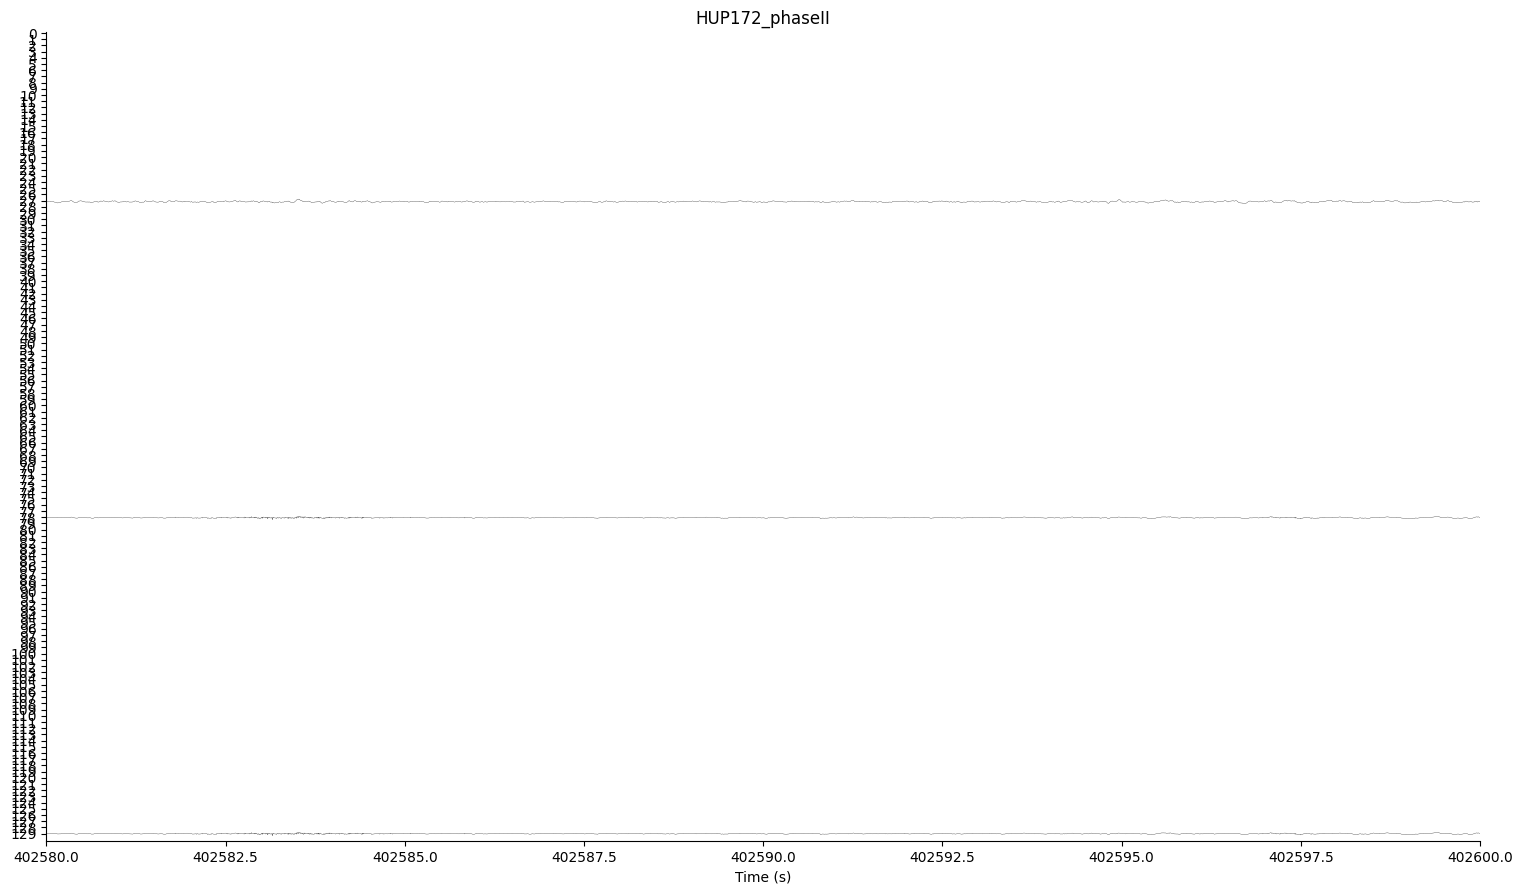

In [12]:
#@title Plot data
#@markdown Generate
t_sec = np.linspace(param['start'], param['stop'], num=data['car_data'].shape[0])
fig, ax = tools.plot_iEEG_data(data['car_data'], t_sec)
fig.set_size_inches(18.5, 10.5)
ax.set_title(param['filename'])

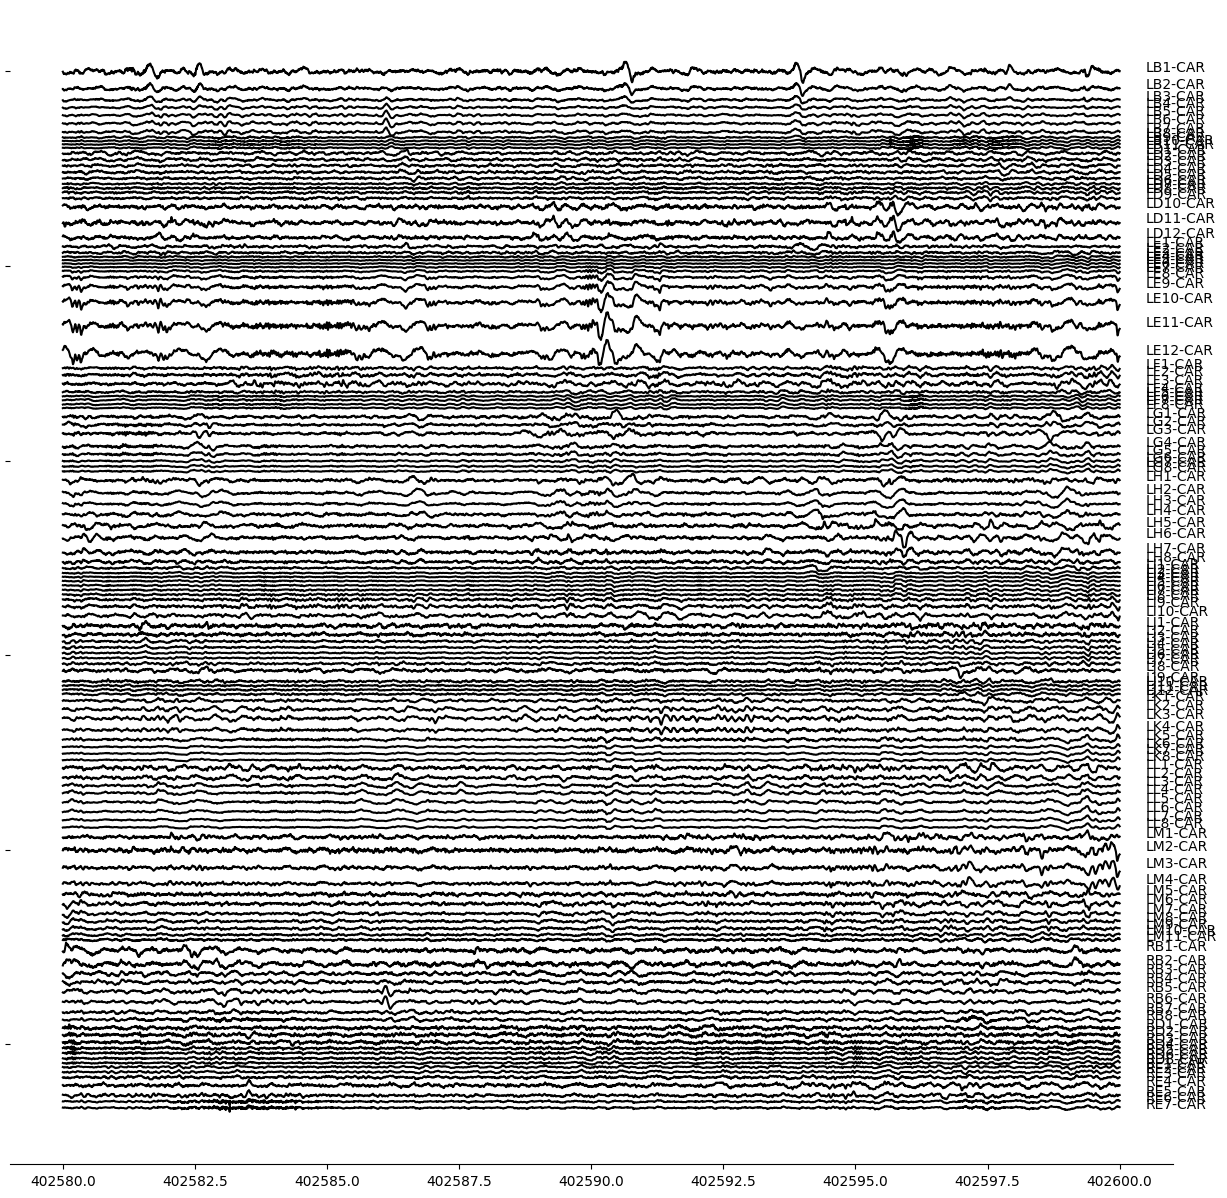

In [13]:
# works similar to the plot on the top, I wasn't sure exactly what you wanted to show
# so i made this function and added it to tools to display a full range of eeg data w/ channel labels

fig = tools.plot_iEEG_data_v2(data['car_data'], data['car_chs'], t_sec)


## Batch Processing
Code for parallel processing of multiple data files

In [22]:
#@title Settings
#@markdown Get Data via File:
#@markdown
#@markdown Specify the path to file containing data info (.csv/.tsv)
#@markdown Format Filename | Start time | Stop time | Electrodes
file_path = "test/getData_testInput.csv" # @param {type:"string"}

#@markdown Filtering Settings:

low_freq = 1 # @param {type:"number"}
high_freq = 120 # @param {type:"number"}
notch = 60 # @param {type:"number"}

#@markdown Re-ref method Setting:
ref = "CAR" # @param ["CAR", "BR", "LAR"]

#@markdown Save data:
save = True # @param {type:"boolean"}

import pickle
def save_file(data,filename):
  with open(filename+'.pkl', 'wb') as fp:
      pickle.dump(data, fp)

In [23]:
#@title Implementation
with open(os.path.join(path,"config.json"), 'rb') as f:
    config = pd.read_json(f, typ='series')

param = pd.read_csv(file_path)

#tmp fix
param = param.iloc[:2,:3]
param_dict = []
for i in range(param.shape[0]):
  param_dict.append(param.iloc[i,:].to_dict())

for i in range(len(param_dict)):
  param = param_dict[i]
  data = tools.get_ieeg_data(config.usr, config.pwd, param['filename'], param['start'], param['stop'])
  data = {'data':data[0],
          'ch_names':data[1],
          'fs':data[2],
  }
  data['ch_names'] = tools.clean_labels(data['ch_names'])
  data['nonieeg'] = tools.find_non_ieeg(data['ch_names'])
  data['bad'],data['bad_reasons'] = tools.identify_bad_chs(data['data'],data['fs'])
  data['clean_data'] = data['data'][:,~data['nonieeg']&~data['bad']]
  data['clean_chs'] = data['ch_names'][~data['nonieeg']&~data['bad']]
  data['filtered'] = tools.bandpass_filter(data['clean_data'],data['fs'],low_freq,high_freq)
  data['filtered'] = tools.notch_filter(data['filtered'],data['fs'],notch)
  if ref == 'CAR':
    data['car_data'], data['car_chs'] = tools.car(data['filtered'], data['clean_chs'])
  elif ref == 'BR':
    data['br_data'], data['br_chs'] = tools.bipolar(data['filtered'], data['clean_chs'])
  if save:
    save_file(data,'_'.join([param['filename'],str(param['start']),str(param['stop'])]))


# add full settings
# add save figure, etc.